# Dataset_Maker_Junctions

### Description:

Script to create dataset of junctions. Includes 2 methods: one introduced by Field of Junctions, and a second based off of M-Junctions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from types import SimpleNamespace
import sys
sys.path.append('..')
from field_of_junctions import FieldOfJunctions
import pickle, os
from PIL import Image

dev = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Method 1: FOJ

In [2]:
def make_random_junction_set(num_samples,img_size,center_range,opts,dev,eta=.01,delta=.02):

#     img_size = 64
    img = np.zeros((img_size,img_size,1))

    opts.R                        = img_size
    opts.stride                   = img_size
    opts.eta                      = 0.01
    opts.delta                    = 0.02
    opts.lr_angles                = 0.003
    opts.lr_x0y0                  = 0.03
    opts.lambda_boundary_final    = 0.5
    opts.lambda_color_final       = 0.1
    opts.nvals                    = 31
    opts.num_initialization_iters = 30
    opts.num_refinement_iters     = 1000
    opts.greedy_step_every_iters  = 50
    opts.parallel_mode            = True

#     dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    foj = FieldOfJunctions(img, dev, opts)

    # Bounds of image: [-1,1],[-1,1]
    # Randomly generate junction location from [-3,3],[3,3] and 3 angles between [0,2*pi]

#     jcenter = 2*torch.rand(num_samples,2) - 1
#     jangles = 2*np.pi*torch.rand(num_samples,3) - np.pi
    jangles = 2*np.pi*torch.sort(torch.rand(num_samples,3))[0].to(dev)
#     jcenter = .9*torch.rand(num_samples,2).to(device) - .9

    jcenter = (center_range*torch.rand(num_samples,2) - center_range).to(dev)

    params = torch.cat([jangles,jcenter],dim=1).unsqueeze(2).unsqueeze(3)
    
    dists = foj.params2dists(params)
    wedges = foj.dists2indicators(dists).squeeze(-1).squeeze(-1)


    return dists,wedges,params,foj


def make_grey_transform_junc(num_images,dev,opt=0):
    
    if opt == 0:
        return torch.tensor([0,.5,1]).unsqueeze(0).unsqueeze(2).unsqueeze(2)

    if opt == 1:  

        grey_transform = torch.zeros((num_images,3,1,1),device=dev)

        num_grey_schemes = 0
        while num_grey_schemes<num_images:
            
            sample = torch.rand(3,device=dev).sort()[0]

            if torch.min(torch.diff(sample))<.2:
                continue

            grey_transform[num_grey_schemes,:,:,:] = sample.unsqueeze(1).unsqueeze(1)

            num_grey_schemes += 1

        return grey_transform

tensor([[[0.4647]],

        [[1.0585]],

        [[5.0403]],

        [[0.0000]],

        [[0.0000]]])


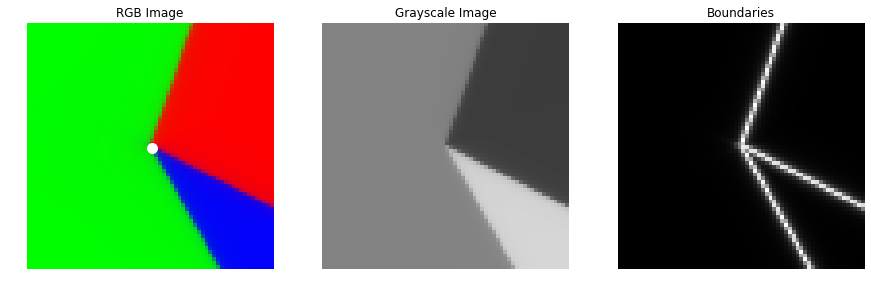

In [3]:
# Test that the code runs for 1 example

opts = SimpleNamespace()

R = 32

center_range = .2 # default

dists,wedges,params,foj = make_random_junction_set(1,R,center_range,opts,'cpu')

grey_transform = make_grey_transform_junc(wedges.shape[0],'cpu',opt=1)

dists,wedges,params,foj = make_random_junction_set(1,64,0,opts,dev)
grey_transform = make_grey_transform_junc(wedges.shape[0],dev,opt=1)

wedges_grey = (wedges*grey_transform).sum(1)
boundaries = foj.dists2boundaries(dists).squeeze(1).squeeze(3).squeeze(3)


img_show = 0

# TO DO: figure out how to plot the junction center!!
junction_center = (params[img_show,-2:,:,:].squeeze()*32 + 32).cpu()

# print(junction_center)

plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].permute(1,2,0).cpu().detach())
plt.plot(junction_center[0],junction_center[1],'wo',markersize=10)
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].cpu().detach(),cmap='gray',vmin=0,vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].cpu().detach(),cmap='gray',vmin=0,vmax=1)
plt.title('Boundaries')
plt.axis('off');

print(params[0])

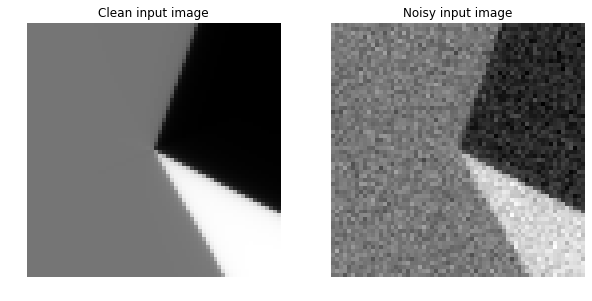

In [4]:
# Add noise
clean_img = wedges_grey[img_show,:,:]

# Add noise
img = clean_img + .05*np.random.randn(*clean_img.shape)
mn, mx = img.min(), img.max()

# Adjust contrast (equally to both images)
img = (img - mn) / (mx - mn)
clean_img = (clean_img - mn) / (mx - mn)

plt.figure(figsize=[10, 10])
plt.subplot(121)
plt.imshow(clean_img,cmap='gray')
plt.title('Clean input image')
plt.axis('off');
plt.subplot(122)
plt.imshow(img,cmap='gray')
plt.title('Noisy input image')
plt.axis('off');

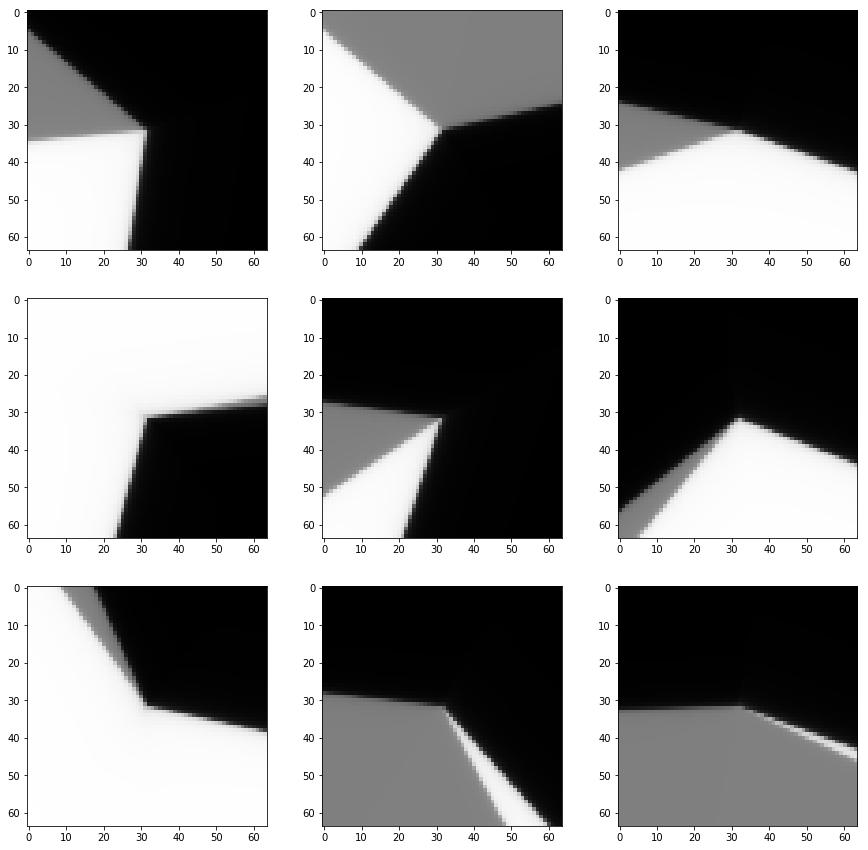

In [6]:
# Create a basic junction dataset with

# A pickle file containing:
# wedges
# wedges grey
# params
# boundaries

num_samples = 20000
num_samples_orig = num_samples
R = 64
add_solid = 0
add_noise = 0
center_range = 0
gen_colors = 0


opts = SimpleNamespace()
dists,wedges,params,foj = make_random_junction_set(num_samples,R,center_range, opts,'cpu');
grey_transform = make_grey_transform_junc(num_samples,'cpu',gen_colors);


wedges_grey = (wedges*grey_transform).sum(1).unsqueeze(1)
boundaries = foj.dists2boundaries(dists).squeeze(1).squeeze(3).squeeze(3)

if add_solid:
    
    num_samples_add = round(.25*num_samples_orig)
    
    wedges = torch.cat((wedges,torch.ones(num_samples_add,3,R,R)),dim=0);
    
    wedges_grey = torch.cat((wedges_grey,torch.ones(num_samples_add,1,R,R)*torch.rand(num_samples_add).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)),dim=0)
    boundaries = torch.cat((boundaries,torch.ones(num_samples_add,R,R)),dim=0);
    params = torch.cat((params,torch.ones(num_samples_add,5,1,1)*torch.tensor((0,0,0,5,5)).reshape(1,5,1,1)),dim=0)
    
    num_samples += num_samples_add


if add_noise:
    wedges_grey = wedges_grey + .2*torch.rand(num_samples).unsqueeze(1).unsqueeze(1).unsqueeze(1)*torch.rand(*wedges_grey.shape)#,device=dev)
    mn, mx = wedges_grey.min(), wedges_grey.max()

    # Adjust contrast (equally to both images)
    wedges_grey = (wedges_grey - mn) / (mx - mn)

    
wedge_data = {'wedges':wedges,
                 'wedges_grey':wedges_grey,
                 'params': params,
                 'boundaries':boundaries}

data_folder = 'Data/grayscale_junctions/'

# if folder doesn't exist, make it
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

with open(data_folder + 'junction_data_64_20000_fixed_color_center_range_0.pkl', 'wb') as f:
    pickle.dump(wedge_data, f)

plt.figure(figsize=[15, 15])

for ii in range(9):

    plt.subplot(3,3,ii+1)
    plt.imshow(wedges_grey[-ii,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
#     print(params[-ii,:])



In [7]:
print(wedges_grey.shape)

torch.Size([20000, 1, 64, 64])


# Method 2: M-Junctions

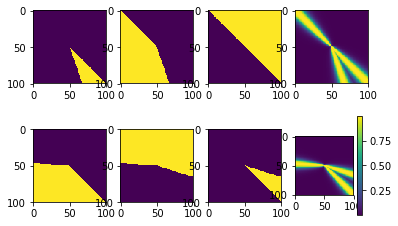

In [21]:
import torch.nn.functional as F

class MultiJunction:
    def __init__(self, order, dev, vertex=None, angle=None, wedges=None):
        """
        Inputs
        ------
        order     Junction order, i.e. number of wedges per junction (positive integer)
        vertex    (x,y) coordinates of vertices for each junction. Accepts an N x 2 array of coordinates
                  If this argument is omitted, the default value is (0.0,0.0).
        angle     Angles in radians representing overall orientation for each junction. Length N array.
                  If this argument is omitted, the default value is 0.0.
        wedges    Relative solid angles of wedges. 2D array of size N x order.
                  If this argument is omitted, the default value is an array of ones
                  (so all wedges have equal solid angles).
        
        Note:     The entries of "wedges" need not sum to 2*pi; they are
                  normalized internally. Also, "wedges" cannot be all zeros.
        """

        # Make sure order is a positive integer
        if isinstance(order, int):
              if order <= 0:
                raise ValueError("Junction order must be a positive integer")
        elif isinstance(order, float):
              if not order.is_integer() or order <= 0:
                raise ValueError("Junction order must be a positive integer")
        else:
              raise ValueError("Junction order must be a positive integer")
                
        self.order = int(order)
        
        # Define wedge vertex
        self.vertex = vertex if vertex is not None else torch.zeros((1,2),device=dev)

        # Define global orientation
        self.angle = angle if angle is not None else 0.0

        # Define wedge solid angles, and normalize for summing to 2*pi
        self.wedges = wedges if wedges is not None else torch.ones((1,order),device=dev)
        self.wedges = self.wedges*(2*torch.pi)/torch.sum(self.wedges,1).unsqueeze(1)
        
        padding = [(1)] + [(0)]
        
        # Compute wedge central angles
        self.centralangles = self.angle.unsqueeze(1) + self.wedges/2 + F.pad(torch.cumsum(self.wedges,dim=1)[:,:-1],padding)

        # Compute wedge boundary angles
        self.boundaryangles = self.angle.unsqueeze(1) + F.pad(torch.cumsum(self.wedges,dim=1)[:,:-1],padding)


    def render_wedges(self,opts,dev):
        """
        Test whether point (xt,yt) is in jth wedge

        Inputs
        ------
        xt, yt          xt is a 1D array of x points being tested, yt is a 1D array of y points being tested

        Output
        ------
        indicator       Binary array: N x |xt| x |yt| x J, where J is order of the junction

        """
        
        xt = torch.linspace(opts.patchmin, opts.patchmax, opts.patchres, device=dev).unsqueeze(0)
        yt = torch.linspace(opts.patchmin, opts.patchmax, opts.patchres, device=dev).unsqueeze(-1)
                
        indicator = (xt.unsqueeze(-1).unsqueeze(0) - self.vertex[:,0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)) \
                        * torch.cos(self.centralangles).unsqueeze(1).unsqueeze(1) + \
                    (yt.unsqueeze(-1).unsqueeze(0) - self.vertex[:,1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)) \
                        * torch.sin(self.centralangles).unsqueeze(1).unsqueeze(1)  > \
                    torch.cos(self.wedges/2).unsqueeze(1).unsqueeze(1) * \
                       torch.sqrt((xt.unsqueeze(-1).unsqueeze(0) - self.vertex[:,0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))**2 + \
                               (yt.unsqueeze(-1).unsqueeze(0) - self.vertex[:,1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))**2)
        
        return indicator

    def render_boundaries(self,opts,dev):
        """
        Render an image of the wedge boundaries over a square patch

        Inputs
        ------
        opts   Object with the following attributes:
               patchmin          Lower bound (xmin = ymin) of square domain
               patchmax          Upper bound (xmax = ymax) of square domain
               patchres          Number of pixels in each dimension
               delta             Dirac delta relaxation parameter for rendering boundary maps   
             
        Output
        ------
        im    Image of size [patchres, patchres] with values in [0,1]
        """

        # coordinate grid of pixel locations 
        x = torch.linspace(opts.patchmin, opts.patchmax, opts.patchres, device=dev).unsqueeze(0)
        y = torch.linspace(opts.patchmin, opts.patchmax, opts.patchres, device=dev).unsqueeze(-1)
  
        # Loop over wedge-boundaries and store their boundary maps.
        # Use [1 / (1 + (x/opts.delta)**2 )] for the relaxed dirac distribution 
        ims = 1.0 / (1.0 + (( (x.unsqueeze(-1).unsqueeze(0) - self.vertex[:,0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)) * torch.cos(self.boundaryangles).unsqueeze(1).unsqueeze(1) + \
                       (y.unsqueeze(-1).unsqueeze(0) - self.vertex[:,1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)) * torch.sin(self.boundaryangles).unsqueeze(1).unsqueeze(1) - \
                        torch.sqrt((x.unsqueeze(-1).unsqueeze(0) - self.vertex[:,0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))**2 + \
                                   (y.unsqueeze(-1).unsqueeze(0) - self.vertex[:,1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))**2)) \
                      / opts.delta )**2 )  
        
        return torch.amax(ims,dim=-1)

    
opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  100    # Number of pixels in each dimension of square patch
opts.delta                    =  .01   # Dirac delta relaxation parameter for rendering boundary maps

# create 3-junction with default properties
order = 3
centers = torch.zeros((3,2)).to(dev)
angles = torch.tensor((torch.pi/4, torch.pi/4, torch.pi/6)).to(dev)
solid_angles = torch.tensor([[.1,.6,.7],[.5,.7,.1],[.2,.6,.1]]).to(dev)

jn = MultiJunction(order, dev, centers, angles, solid_angles)
    
    
# render indicator functions of all wedges and boundaries
w = jn.render_wedges(opts,dev).cpu()
b = jn.render_boundaries(opts,dev).cpu()

plt.figure()
plt.subplot(241)
plt.imshow(w[0,:,:,0])
plt.subplot(242)
plt.imshow(w[0,:,:,1])
plt.subplot(243)
plt.imshow(w[0,:,:,2])
plt.subplot(244)
plt.imshow(b[0,:,:])
plt.subplot(245)
plt.imshow(w[1,:,:,0])
plt.subplot(246)
plt.imshow(w[1,:,:,1])
plt.subplot(247)
plt.imshow(w[1,:,:,2])
plt.subplot(248)
plt.imshow(b[1,:,:])
plt.colorbar()

# There are 2 ways to do this: I could either select 3 angles between 0 and 2 pi and then convert it to an M-junction parameterization to find the image, or I could just use the M-junction parameterization from the start....I will start with the later

In [ ]:
# NOTE TO SELF: M-Junction Parameterization!!

In [27]:
def make_random_junction_set(MultiJunction,num_samples,img_size,center_range,dev,opts,eta=.01,delta=.02):

    jangles = torch.rand(num_samples,3).to(dev)
    jangles = jangles/jangles.sum(axis=1).unsqueeze(1) * 2*torch.pi
    
    jalpha = torch.rand(num_samples).to(dev) * 2*torch.pi
    
    jcenter = (center_range*torch.rand(num_samples,2) - center_range).to(dev)

    jn = MultiJunction(3, dev, jcenter, jalpha, jangles)

    wedges = jn.render_wedges(opts,dev).cpu()
    boundaries = jn.render_boundaries(opts,dev).cpu()
    
    params = torch.cat([jalpha.unsqueeze(1),jangles,jcenter],dim=1)

    return wedges,boundaries,params

def make_grey_transform_junc(num_images,dev,opt=0):
    
    if opt == 0:
        return torch.tensor([0,.5,1]).unsqueeze(0).unsqueeze(2).unsqueeze(2)

    if opt == 1:  

        grey_transform = torch.zeros((num_images,1,1,3),device=dev)

        num_grey_schemes = 0
        while num_grey_schemes<num_images:
            
            sample = torch.rand(3,device=dev).sort()[0]

            if torch.min(torch.diff(sample))<.2:
                continue

            grey_transform[num_grey_schemes,:,:,:] = sample.unsqueeze(0).unsqueeze(0)

            num_grey_schemes += 1

        return grey_transform
    

torch.Size([50000, 1, 12, 12])
torch.Size([50000, 12, 12])


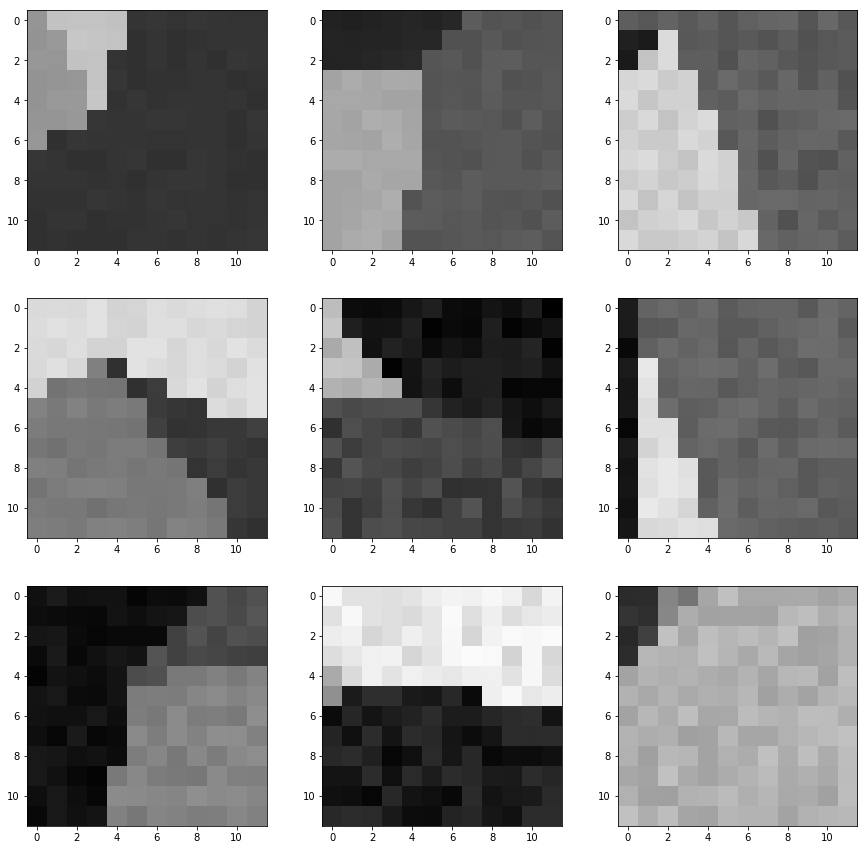

In [24]:
# Create a basic junction dataset with
num_samples = 50000
R = 12
add_noise = 1
center_range = 1

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  R    # Number of pixels in each dimension of square patch
opts.delta                    =  .01   # Dirac delta relaxation parameter for rendering boundary maps

wedges,boundaries,params = make_random_junction_set(MultiJunction,num_samples,R,center_range,'cpu', opts);
grey_transform = make_grey_transform_junc(num_samples,'cpu',1);


wedges_grey = (wedges*grey_transform).sum(3).unsqueeze(1)

print(wedges_grey.shape)
print(boundaries.shape)

add_solid = 0
if add_solid:
    
    num_samples_add = round(.25*num_samples_orig)
    
    wedges = torch.cat((wedges,torch.ones(num_samples_add,3,R,R)),dim=0);
    
    wedges_grey = torch.cat((wedges_grey,torch.ones(num_samples_add,1,R,R)*torch.rand(num_samples_add).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)),dim=0)
    boundaries = torch.cat((boundaries,torch.ones(num_samples_add,R,R)),dim=0);
    params = torch.cat((params,torch.ones(num_samples_add,5,1,1)*torch.tensor((0,0,0,5,5)).reshape(1,5,1,1)),dim=0)
    
    num_samples += num_samples_add


if add_noise:
    wedges_grey = wedges_grey + .2*torch.rand(num_samples).unsqueeze(1).unsqueeze(1).unsqueeze(1)*torch.rand(*wedges_grey.shape)#,device=dev)
    mn, mx = wedges_grey.min(), wedges_grey.max()

    # Adjust contrast (equally to both images)
    wedges_grey = (wedges_grey - mn) / (mx - mn)

    
wedge_data = {'wedges':wedges,
                 'wedges_grey':wedges_grey,
                 'params': params,
                 'boundaries':boundaries}

data_folder = 'Data/grayscale_junctions/'

# if folder doesn't exist, make it
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

with open(data_folder + 'M-junction_data_12_50000_grey_multicolor_noise_level_.2_center_range_1.pkl', 'wb') as f:
    pickle.dump(wedge_data, f)

plt.figure(figsize=[15, 15])

for ii in range(9):

    plt.subplot(3,3,ii+1)
    plt.imshow(wedges_grey[-ii,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
#     print(params[-ii,:])

